In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
case = 'UC25ED13_ES5GW_1yr'
n = 25

def skip_rows(index, n):
    return index % n >= 24

RTPrice = pd.read_csv('output/'+case+'/EDprice.csv',header=None)*12
DAPrice = pd.read_csv('output/'+case+'/UCprice.csv',header=None)
UCGen = pd.read_csv('output/'+case+'/UCGenZone.csv',header=None, skiprows=lambda x: skip_rows(x, n))
UCCommit = pd.read_csv('output/'+case+'/UCCommit.csv',header=None, skiprows=lambda x: skip_rows(x, n))
UCReGenZone = pd.read_csv('output/'+case+'/UCRenewableZone.csv',header=None, skiprows=lambda x: skip_rows(x, n))
UCHydroGenZone = pd.read_csv('output/'+case+'/UCHydroZone.csv',header=None, skiprows=lambda x: skip_rows(x, n))
UCSoCZone = pd.read_csv('output/'+case+'/UCSoCZone.csv',header=None, skiprows=lambda x: skip_rows(x, n))
UCTransZone = pd.read_csv('output/'+case+'/UCTrans.csv',header=None, skiprows=lambda x: skip_rows(x, n))
EDGen = pd.read_csv('output/'+case+'/EDGenZone.csv',header=None)
EDReGenZone = pd.read_csv('output/'+case+'/EDRenewableZone.csv',header=None)
EDHydroGenZone = pd.read_csv('output/'+case+'/EDHydroZone.csv',header=None)
EDSoCZone = pd.read_csv('output/'+case+'/EDSoCZone.csv',header=None)

# Define the time range
# time = range(len(RTPrice))
time = range(0,2016)
# time = range(57600, 59616)
# time = range(13248, 15264)

In [3]:
UCGen = UCGen.loc[UCGen.index.repeat(12)].reset_index(drop=True)
UCCommit = UCCommit.loc[UCCommit.index.repeat(12)].reset_index(drop=True)
UCReGenZone = UCReGenZone.loc[UCReGenZone.index.repeat(12)].reset_index(drop=True)
UCHydroGenZone = UCHydroGenZone.loc[UCHydroGenZone.index.repeat(12)].reset_index(drop=True)
UCSoCZone = UCSoCZone.loc[UCSoCZone.index.repeat(12)].reset_index(drop=True)
UCTransZone = UCTransZone.loc[UCTransZone.index.repeat(12)].reset_index(drop=True)


In [4]:
RTLoad = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/realtimeload_C_R.csv',header=None,usecols=range(1, 8))
new_columns = {i: i - 1 for i in range(1, 8)}
RTLoad.rename(columns=new_columns, inplace=True)
load = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/Load_C.csv').iloc[:,1:].values
solarmap = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/SolarMap_C.csv').iloc[:,1:].values
solarprofile = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/SolarProfile_C.csv').iloc[:,1:].values
windmap = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/WindMap_C.csv').iloc[:,1:].values
windprofile = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/WindProfile_C.csv').iloc[:,1:].values
hydromap = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/HydroMap_C.csv').iloc[:,1:].values
hydroprofile = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/HydroProfile_C.csv').iloc[:,1:].values

In [5]:
solargen = np.matmul(solarprofile,solarmap)
windgen = np.matmul(windprofile,windmap)
hydrogen = np.matmul(hydroprofile,hydromap)

In [6]:
# df1 = pd.DataFrame(load - solargen - windgen - hydrogen)
DAREGen = pd.DataFrame(- solargen - windgen - hydrogen)

In [7]:
new_index = np.arange(0, len(DAREGen), 1/12)
new_index = np.round(new_index, decimals=6)  # To prevent floating point issues

# Reindex and interpolate
RTREGen = DAREGen.reindex(new_index)
RTREGen = RTREGen.interpolate(method='linear')

# Reset the index for the new DataFrame
RTREGen.reset_index(drop=True, inplace=True)

In [8]:
EDREGen = pd.DataFrame(EDReGenZone.values + EDHydroGenZone.values)
RTNetGen = pd.DataFrame(RTLoad.iloc[range(len(RTPrice)),:].values - EDREGen.iloc[range(len(RTPrice)),:].values)

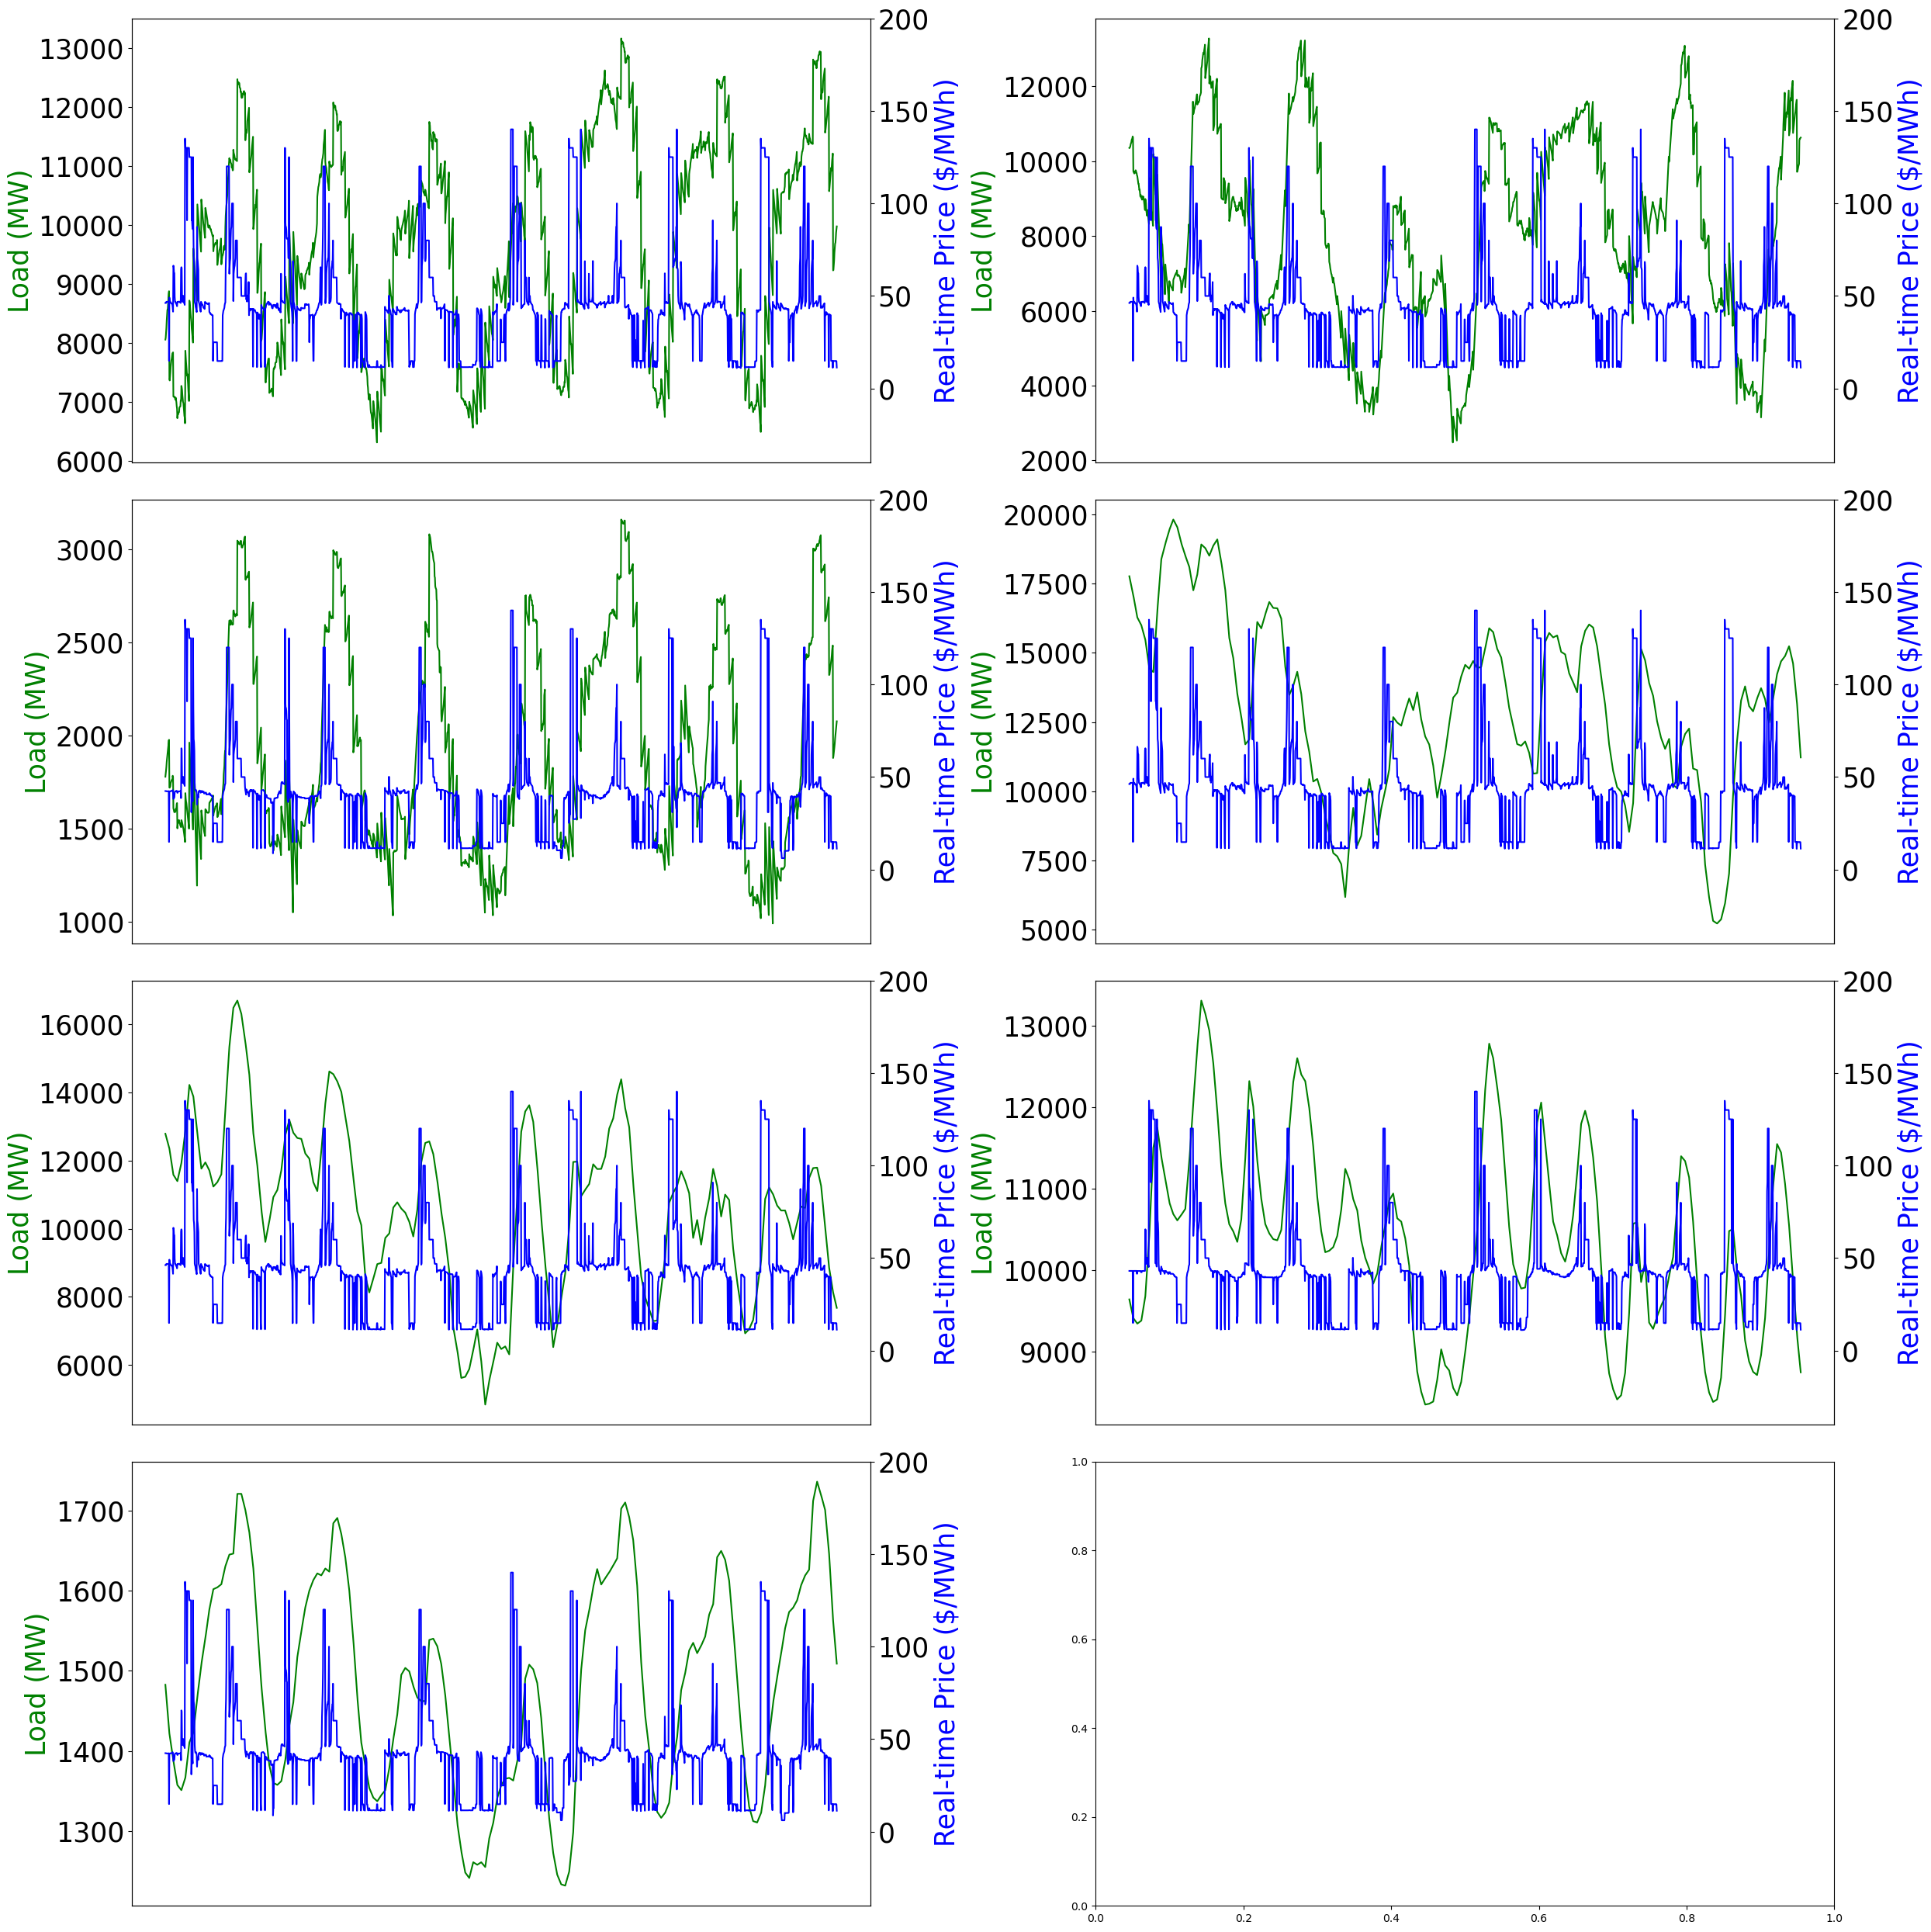

In [19]:
#real-time price plot

# Create the figure and subplots, adjusting for a 16:9 ratio
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))

# Remove the extra, unused subplot (axes[1, 3])
# fig.delaxes(axes[1][3])

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each zone
for i in range(7):
    # Plot load and price for each zone
    ax1 = axes[i]
    ax2 = ax1.twinx()

    ax1.plot(time, RTNetGen.iloc[time, i], 'g-')
    ax2.plot(time, RTPrice.iloc[time, i], 'b-')

    # Set y-axis limits
    ax2.set_ylim(-40, 200)

    # Set labels
    ax1.set_ylabel('Load (MW)', color='g', fontsize=25)
    ax2.set_ylabel('Real-time Price ($/MWh)', color='b',fontsize=25)
    ax1.tick_params(axis='both', which='major', labelsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=25)
#     ax1.set_xlabel('Time Period', fontsize=25)
    ax1.set_xticks([])

    # Set title for each subplot
#     ax1.set_title(f'Region {i+1}')

# Adjust the space between plots
# plt.subplots_adjust(wspace=0.8, hspace=0.3)
plt.tight_layout()

# Show the plot
plt.show()

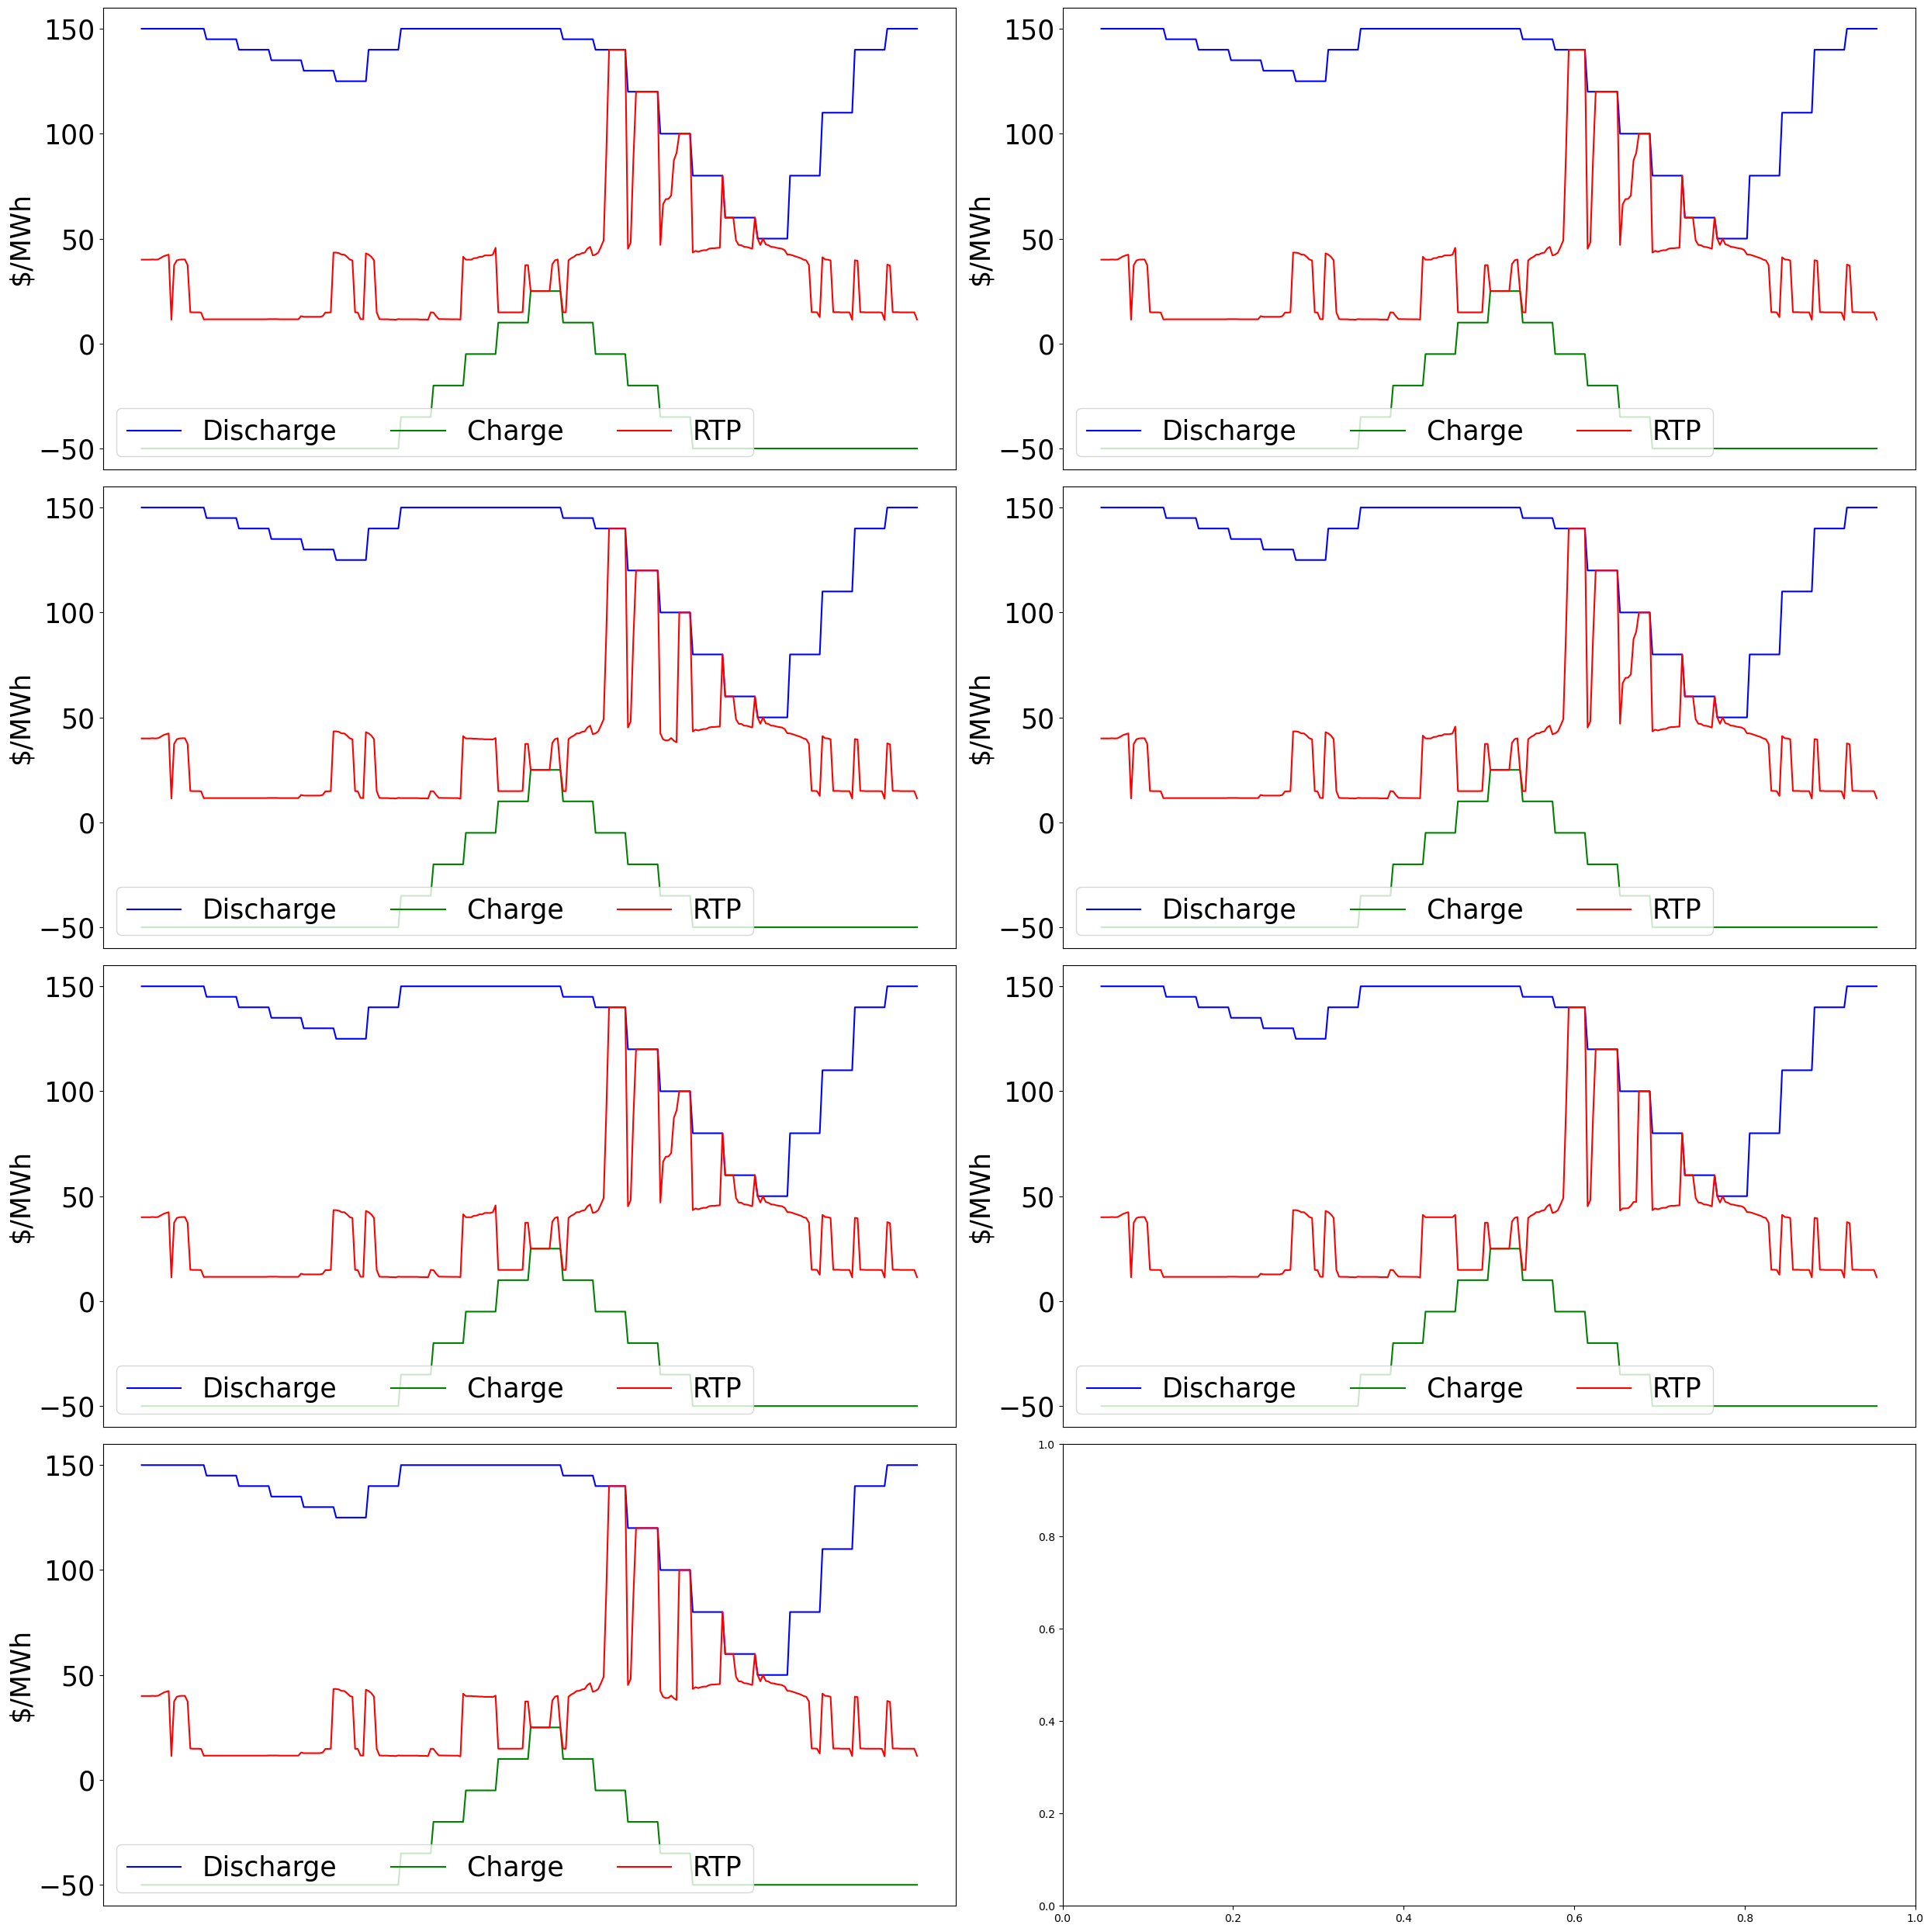

In [18]:
DADBidsSingle = [150, 150, 145, 140, 135, 130, 125, 140, 150, 150, 150, 150, 150, 145, 140, 120, 100, 80, 60, 50, 80,
                110, 140, 150]
DACBidsSingle = [-50, -50, -50, -50, -50, -50, -50, -50, -35, -20, -5, 10, 25, 10, -5, -20, -35, -50, -50, -50, -50,
                -50, -50, -50]
DADBidsSingle_exp = [val for val in DADBidsSingle for _ in range(12)]
DACBidsSingle_exp = [val for val in DACBidsSingle for _ in range(12)]

# Create the figure and subplots, adjusting for a 16:9 ratio
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
flat_axes = axes.ravel()

# Remove the extra, unused subplot (axes[1, 3])
# fig.delaxes(axes[1][3])
a = 3

for i in range(7):  # Since there are 7 columns in the dataframe
    flat_axes[i].plot(range(a*288,(a+1)*288),DADBidsSingle_exp, label="List 1", color='blue')
    flat_axes[i].plot(range(a*288,(a+1)*288),DACBidsSingle_exp, label="List 2", color='green')
    flat_axes[i].plot(RTPrice.iloc[a*288:(a+1)*288, i], label=f"Col {i+1}", color='red')  # plot the first 288 rows of each column
    flat_axes[i].legend(['Discharge','Charge','RTP'],loc='lower left', ncol = 3, fontsize=25)
#     flat_axes[i].set_title(f"Region {i+1}",fontsize=20)
#     flat_axes[i].set_xlabel("Time Period",fontsize=20)
    flat_axes[i].set_ylabel("$/MWh",fontsize=25)
    flat_axes[i].tick_params(axis='both', which='major', labelsize=25)
    flat_axes[i].set_xticks([])


plt.tight_layout()
plt.show()


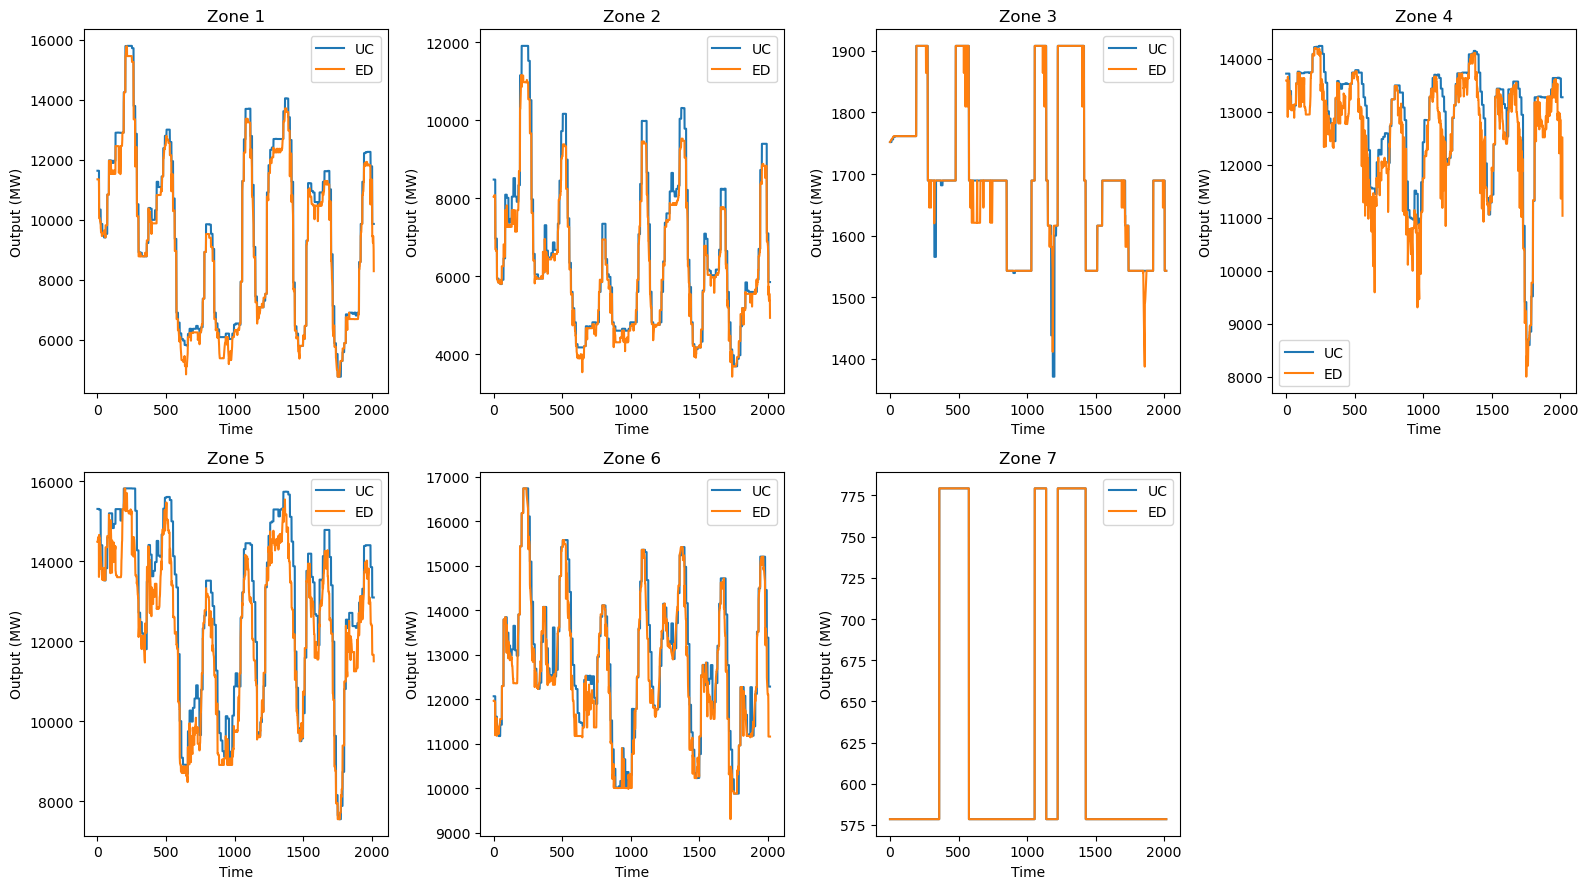

In [20]:
# zonal thermal generation compared to commited gpmin gpmax

UCGenCompare = [UCGen,EDGen]

fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig.delaxes(axs[1][3])


# Reshape axs to a 1D array for easier iteration
axs = axs.flatten()

# Iterate through each column and each subplot
for ax, col in zip(axs, UCGen.columns):
    for i, df in enumerate(UCGenCompare):
        ax.plot(df[col][time], label=f'DataFrame {i+1}')  
    ax.set_title(f'Zone {col+1}')
    ax.legend(['UC','ED','RTLoad'])
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Output (MW)')

plt.tight_layout()
plt.show()

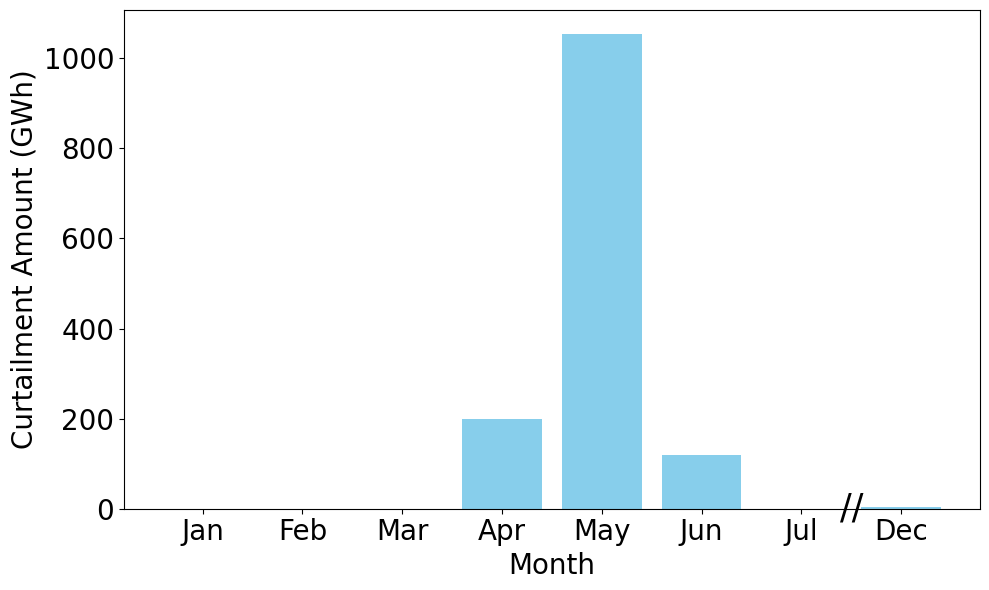

In [51]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Dec']
MonthlyCurtailment = [0, 0, 0, 198813.63323123925, 1054420.8380122916, 119757.05632579878, 0, 3950.4223412795736]
ScaledCurtailment = [x/1000 for x in MonthlyCurtailment]

# Plot
plt.figure(figsize=(10,6))
plt.bar(months, ScaledCurtailment, color='skyblue')
plt.ylabel('Curtailment Amount (GWh)',fontsize=20)
plt.xlabel('Month',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.annotate('//', (6.5,0), xycoords='data', fontsize=25, ha='center', va='center')

plt.show()

In [28]:
RTREGen

,0,1,2,3,4,5,6
0,-875.440147,-778.958991,-12.482060,-16282.589370,-4799.058795,-1320.764410,-0.160000
1,-880.264639,-783.327201,-12.526227,-16233.767943,-4798.467556,-1316.865152,-0.146667
2,-885.089130,-787.695411,-12.570393,-16184.946515,-4797.876318,-1312.965893,-0.133333
3,-889.913622,-792.063621,-12.614560,-16136.125088,-4797.285079,-1309.066635,-0.120000
4,-894.738114,-796.431831,-12.658727,-16087.303660,-4796.693840,-1305.167377,-0.106667
...,...,...,...,...,...,...,...
105403,-882.060917,-2416.621698,-148.570450,-17397.834751,-6323.308985,-496.195740,-14.800000
105404,-882.060917,-2416.621698,-148.570450,-17397.834751,-6323.308985,-496.195740,-14.800000
105405,-882.060917,-2416.621698,-148.570450,-17397.834751,-6323.308985,-496.195740,-14.800000
105406,-882.060917,-2416.621698,-148.570450,-17397.834751,-6323.308985,-496.195740,-14.800000


In [50]:
curtaildf = pd.DataFrame(-RTREGen.iloc[range(len(RTPrice))].values-EDREGen.values)
curtaildf['Total'] = curtaildf.sum(axis=1)
sum(curtaildf['Total'].iloc[96191:103831])

3950.4223412795736

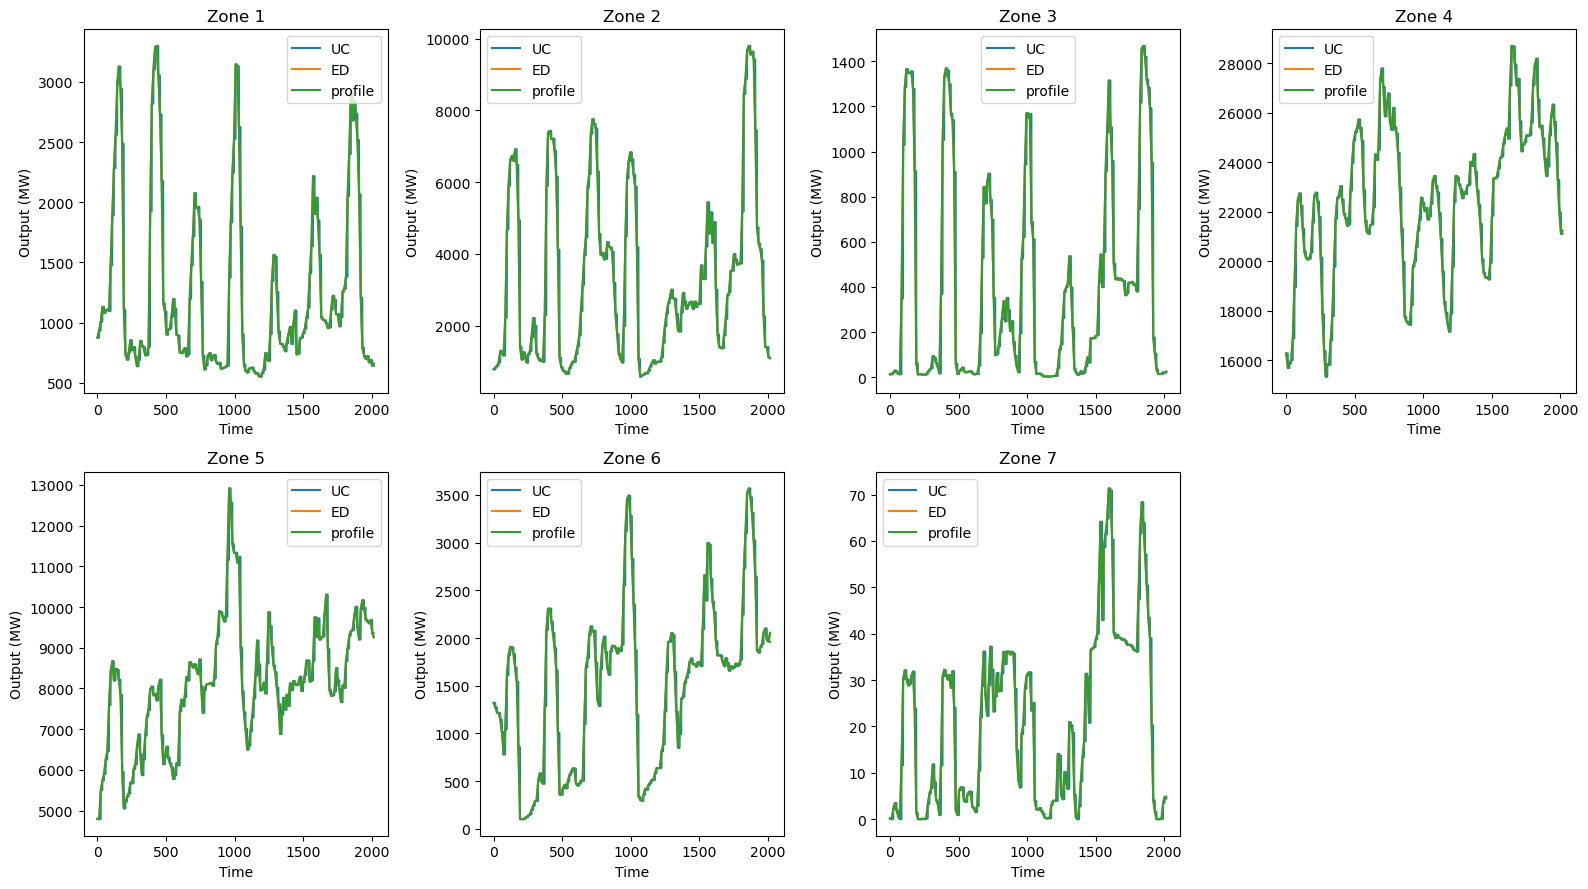

In [21]:
# zonal renewable generation compared to profile
UCREGen = pd.DataFrame(UCReGenZone.values + UCHydroGenZone.values)
EDREGen = pd.DataFrame(EDReGenZone.values + EDHydroGenZone.values)


REGenCompare = [UCREGen,EDREGen,-RTREGen]

fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig.delaxes(axs[1][3])


# Reshape axs to a 1D array for easier iteration
axs = axs.flatten()

# Iterate through each column and each subplot
for ax, col in zip(axs, UCGen.columns):
    for i, df in enumerate(REGenCompare):
        ax.plot(df[col][time], label=f'DataFrame {i+1}')
    ax.set_title(f'Zone {col+1}')
    ax.legend(['UC','ED','profile'])
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Output (MW)')

plt.tight_layout()
plt.show()

In [ ]:
# zonal storage SoC
SoCCompare = [UCSoCZone, EDSoCZone]

fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig.delaxes(axs[1][3])


# Reshape axs to a 1D array for easier iteration
axs = axs.flatten()

# Iterate through each column and each subplot
for ax, col in zip(axs, UCGen.columns):
    for i, df in enumerate(SoCCompare):
        ax.plot(df[col][time], label=f'DataFrame {i+1}')
    ax.set_title(f'Zone {col+1}')
    ax.legend(['UC','Zonal SoC'])
    ax.set_xlabel('Time')
    ax.set_ylabel(f'SoC (MWh)')

plt.tight_layout()
plt.show()

In [ ]:
# zonal total generation compared (exclude transmission and storage) to real-time load
UCTotalGen = pd.DataFrame(UCGen.values + UCREGen.values)
EDTotalGen = pd.DataFrame(EDGen.values + EDREGen.values)
DALoad = pd.DataFrame(load)
DALoad = DALoad.loc[DALoad.index.repeat(12)].reset_index(drop=True)


TotalGenCompare = [UCTotalGen,EDTotalGen,DALoad,RTLoad]

fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig.delaxes(axs[1][3])


# Reshape axs to a 1D array for easier iteration
axs = axs.flatten()

# Iterate through each column and each subplot
for ax, col in zip(axs, UCGen.columns):
    for i, df in enumerate(TotalGenCompare):
        ax.plot(df[col][time], label=f'DataFrame {i+1}')
    ax.set_title(f'Zone {col+1}')
    ax.legend(['UC','ED','DALoad','RTLoad'])
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Output (MW)')

plt.tight_layout()
plt.show()

In [ ]:
# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
# for idx, (col, ax) in enumerate(zip(RTPrice.columns, axs.flatten()))
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(RTPrice[col].values)[::-1]
    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.set_ylim(-50, 200)
    ax.set_title(f"Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)
    
# Remove the last (empty) subpl
# axs[-1, -1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20220107 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')
# Create a 2x4 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip(Pivot_HistoryPrice.columns, axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice[col].values)[::-1]
    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.set_title(f"Price CDF of Hub {Pivot_HistoryPrice.columns[idx]}",fontsize=20)
    ax.set_ylim(-50, 200)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

# Remove the last (empty) subplot
# axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
EDSOCZone = pd.read_csv('output/'+case+'/EDSoCZone.csv',header=None)
EDESZone = pd.DataFrame(index=EDSOCZone.index, columns=EDSOCZone.columns)
for i in range(len(EDSOCZone) - 1):
    diff = (EDSOCZone.iloc[i] - EDSOCZone.iloc[i + 1]) * 0.9 * 12
    EDESZone.iloc[i] = diff.where(diff > 0, 0)

# Set the first row to all zeros
EDESZone.iloc[0] = 0
EDESZone['Total'] = EDESZone.sum(axis=1)

In [ ]:
EDRenewableUnit = pd.read_csv('output/'+case+'/EDRenewable.csv',header=None)
EDSolarUnit = EDRenewableUnit.iloc[:,:solarmap.shape[0]]
EDWindUnit = EDRenewableUnit.iloc[:,solarmap.shape[0]:]
zonal_solar_outputs = EDSolarUnit.values @ solarmap
EDSolarZone = pd.DataFrame(zonal_solar_outputs, columns=[i+1 for i in range(7)])
EDSolarZone['Total'] = EDSolarZone.sum(axis=1)
zonal_wind_outputs = EDWindUnit.values @ windmap
EDWindZone = pd.DataFrame(zonal_wind_outputs, columns=[i+1 for i in range(7)])
EDWindZone['Total'] = EDWindZone.sum(axis=1)
EDHydroGenZone['Total'] = EDHydroGenZone.sum(axis=1)

In [ ]:
EDGenUnit = pd.read_csv('output/'+case+'/EDGen.csv',header=None)
ThermalGenList = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/ThermalGen_Full_C.csv')
nuclear_cols = ThermalGenList[ThermalGenList['Fuel Name'] == 'Uranium'].index
coal_cols = ThermalGenList[ThermalGenList['Fuel Name'].str.startswith('Coal')].index
ng_cols = ThermalGenList[ThermalGenList['Fuel Name'].str.startswith('NG')].index
# oil_cols = ThermalGenList[ThermalGenList['Fuel Name'].str.startswith(('Oil', 'Petroleum'))].index
bio_cols = ThermalGenList[ThermalGenList['Fuel Name'].str.startswith('Bio')].index
geo_cols = ThermalGenList[ThermalGenList['Fuel Name'].str.startswith('Geothermal')].index
others_cols = ThermalGenList.drop(nuclear_cols).drop(coal_cols).drop(ng_cols).drop(bio_cols).drop(geo_cols).index
EDNuclearUnit = EDGenUnit[nuclear_cols]
EDCoalUnit = EDGenUnit[coal_cols]
EDNGUnit = EDGenUnit[ng_cols]
# EDOilUnit = EDGenUnit[oil_cols]
EDBioUnit = EDGenUnit[bio_cols]
EDGeoUnit = EDGenUnit[geo_cols]
EDOthersUnit = EDGenUnit[others_cols]

In [ ]:
def filter_by_type(EDGenUnit, ThermalGenList, fuel_keywords):
    matching_columns = []
    for keyword in fuel_keywords:
        matching_columns.extend(ThermalGenList[ThermalGenList['Fuel Name'].str.startswith(keyword)].index.tolist())
    return EDGenUnit[matching_columns]

def get_zonal_output(df, ThermalGenList):
    # Initialize an empty DataFrame
    df_zonal = pd.DataFrame()
    # For each zone from 1 to 7
    for zone in range(1, 8):
        # Get columns in this zone
        zone_columns = ThermalGenList[(ThermalGenList['Zone'] == zone) & (ThermalGenList.index.isin(df.columns))].index
        # If no generators for this fuel type in the zone, create a zero-filled column
        if len(zone_columns) == 0:
            df_zonal[zone] = 0
        else:
            # Sum up the columns for this zone
            df_zonal[zone] = df[zone_columns].sum(axis=1)
    # Add a total column
    df_zonal['Total'] = df_zonal.sum(axis=1)
    return df_zonal

# Generate zonal dataframes for each fuel type
EDNuclearZone = get_zonal_output(EDNuclearUnit, ThermalGenList)
EDCoalZone = get_zonal_output(EDCoalUnit, ThermalGenList)
EDNGZone = get_zonal_output(EDNGUnit, ThermalGenList)
EDGeoZone = get_zonal_output(EDGeoUnit, ThermalGenList)
EDBioZone = get_zonal_output(EDBioUnit, ThermalGenList)
EDOthersZone = get_zonal_output(EDOthersUnit, ThermalGenList)

In [ ]:
df_combined = pd.DataFrame({
    'Nuclear': EDNuclearZone['Total'],
    'Coal': EDCoalZone['Total'],
    'Geo': EDGeoZone['Total'],
    'Others': EDOthersZone['Total'],
    'Bio': EDBioZone['Total'],
    'NG': EDNGZone['Total'],
    'Hydro': EDHydroGenZone['Total'],
    'Wind': EDWindZone['Total'],
    'Solar': EDSolarZone['Total'],
    'ES': EDESZone['Total']
})

In [ ]:
# time = range(13248, 15264)
time = range(57600, 59616)
# zones_indices = list(range(7)) + [-1]  # -1 refers to the last column for 'total'
zones_indices = [-1]
# Loop through each zone and create a stacked bar plot
for idx in zones_indices:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Order of fuels for stacking
    fuels_order = ['Nuclear', 'Coal', 'Geo', 'Others', 'Bio', 'Hydro', 'Wind', 'Solar', 'NG', 'ES']
    colors = ['#a6a6a6', '#3a3838', '#865320', '#f2a63b',"#4b6732", "#577488", "#aab45e", "#f9da78","#89a3b6", "#ff0000"]
    
    # Dataframes corresponding to each fuel
    dataframes = [EDNuclearZone, EDCoalZone, EDGeoZone, EDOthersZone, EDBioZone, EDHydroGenZone, EDWindZone, EDSolarZone, EDNGZone, EDESZone]
    
    # Bottom value for the stacking
    bottom_value = None
    
    for fuel, df, color in zip(fuels_order, dataframes, colors):
        column_data = df.iloc[time, idx].astype(float)
        
        if bottom_value is None:
            ax.bar(column_data.index, column_data, label=fuel, color = color,width=1)
            bottom_value = column_data.values
        else:
            ax.bar(column_data.index, column_data, label=fuel, bottom=bottom_value.astype(float), color = color,width=1)
            bottom_value += column_data.values
    ax.plot(RTLoad.sum(axis=1)[time],label='Load')
    zone_name = "Total" if idx == -1 else f"Zone {idx+1}"  # idx+1 to shift 0-based index to 1-based
#     ax.set_title(f"Generation Output in {zone_name}")
#     ax.set_xlabel("Time Period",fontsize=20)
    ax.set_ylabel("Generation Output by Fuel (MW)",fontsize=20)
#     ax.legend(loc='upper left', ncol = (len(fuels_order) + 1)/2, fontsize=20)
    ax.set_xticks([])  # Remove x-ticks
    ax.set_xlim(57600, 59616)
    ax.set_ylim(0, 150000)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
CAISONuclear = EDNuclearZone.iloc[:, :3].values.sum()
CAISOCoal = EDCoalZone.iloc[:, :3].values.sum()
CAISOGeo = EDGeoZone.iloc[:, :3].values.sum()
CAISOOther = EDOthersZone.iloc[:, :3].values.sum()
CAISOBio = EDBioZone.iloc[:, :3].values.sum()
CAISONG = EDNGZone.iloc[:, :3].values.sum()
CAISOHydro = EDHydroGenZone.iloc[:, :3].values.sum()
CAISOWind = EDWindZone.iloc[:, :3].values.sum()
CAISOSolar = EDSolarZone.iloc[:, :3].values.sum()

fuels_order = ['Nuclear', 'Coal', 'Geo', 'Other', 'Bio', 'NG', 'Hydro', 'Wind', 'Solar']
colors = ['#a6a6a6', '#3a3838', '#865320', '#f2a63b',"#4b6732","#89a3b6", "#577488", "#aab45e", "#f9da78"]
fuelsimu = [CAISONuclear,CAISOCoal,CAISOGeo,CAISOOther,CAISOBio,CAISONG,CAISOHydro,CAISOWind,CAISOSolar]
fuelactual = [8.67, 0.13, 5.47, 0.18, 2.64, 47.46, 8.67, 6.86,19.92]

fig, axs = plt.subplots(1, 2, figsize=(10, 7))

# Plotting the simulated data
axs[0].pie(fuelsimu, colors=colors, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, textprops={'fontsize': 14})
axs[0].set_title("Simulated CAISO Generation Mix", fontsize=18)

# Plotting the actual data
axs[1].pie(fuelactual, colors=colors, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, textprops={'fontsize': 14})
axs[1].set_title("Actual CAISO Generation Mix", fontsize=18)

# Set a common legend for both subplots
fig.legend(fuels_order, loc="lower center",ncol = len(fuels_order)/3, fontsize=20)

plt.tight_layout()
plt.show()

# plt.figure(figsize=(8,8))

# # Plotting the Pie chart
# plt.pie(fuelsimu, labels=fuels_order, colors=colors, autopct='%1.1f%%', startangle=90)

# # Equal aspect ratio ensures pie is drawn as a circle.
# plt.axis('equal')  

# plt.title('Sample Pie Chart')
# plt.show()

In [82]:
### sensitivity analysis
RTPriceED1 = pd.read_csv('output/UC25ED1_ES5GW/EDprice.csv',header=None)*12
RTPriceED6 = pd.read_csv('output/UC25ED6_ES5GW/EDprice.csv',header=None)*12
RTPriceED13 = pd.read_csv('output/UC25ED13_ES5GW/EDprice.csv',header=None)*12
RTPriceED1D = pd.read_csv('output/UC25ED1_ES5GW_DoubleNoise/EDprice.csv',header=None)*12
RTPriceED6D = pd.read_csv('output/UC25ED6_ES5GW_DoubleNoise/EDprice.csv',header=None)*12
RTPriceED13D = pd.read_csv('output/UC25ED13_ES5GW_DoubleNoise/EDprice.csv',header=None)*12
RTPriceUC25 = pd.read_csv('output/UC25ED13_ES5GW/EDprice.csv',header=None)*12
RTPriceUC36 = pd.read_csv('output/UC36ED13_ES5GW/EDprice.csv',header=None)*12
RTPriceUC48 = pd.read_csv('output/UC48ED13_ES5GW/EDprice.csv',header=None)*12
RTPriceUC72 = pd.read_csv('output/UC72ED13_ES5GW/EDprice.csv',header=None)*12


/var/folders/f2/rxpbf6rd2wjbpqry4k3rs6fr0000gn/T/ipykernel_31214/2879430183.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_xlim(0.0, 1,0)


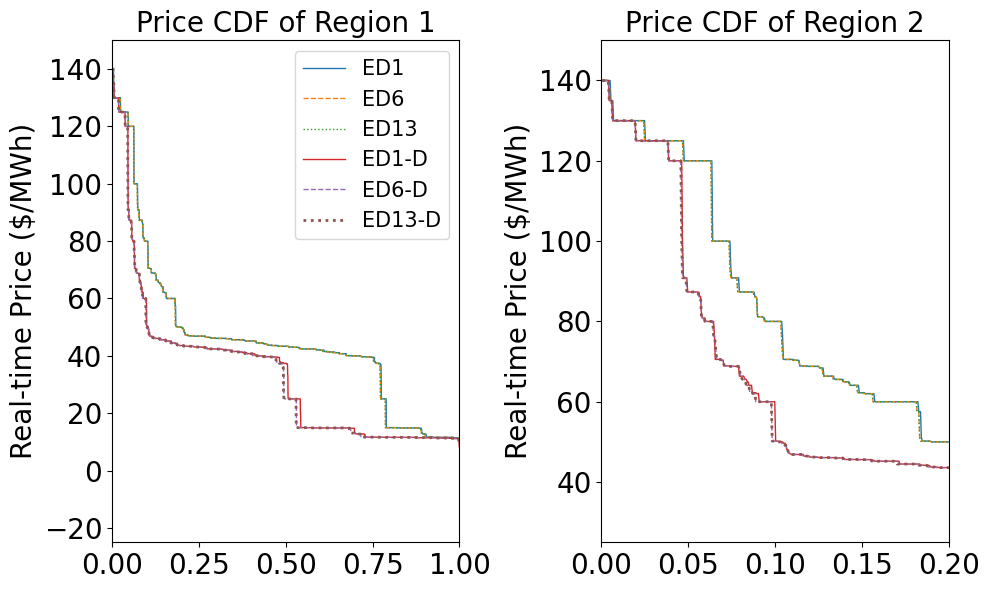

In [115]:
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Define the dataframes and labels
dataframes = [RTPriceED1, RTPriceED6, RTPriceED13, RTPriceED1D, RTPriceED6D, RTPriceED13D]
labels = ['ED1', 'ED6', 'ED13', 'ED1-D', 'ED6-D', 'ED13-D']
i=0
# Loop through each region
for idx, (col, ax) in enumerate(zip([0,0], axs.flatten())):
    # Plot the CDF for each dataframe
    if i == 0:
        for df, label, lw, ls in zip(dataframes, labels, [1,1,1,1,1,2],['-', '--',':','-', '--',':']):
            sorted_vals = np.sort(df[col].values)[::-1]
            cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
            ax.plot(cdf, sorted_vals, label=label, linewidth=lw, linestyle=ls)

        # Set the axis labels and title
        ax.set_ylim(-25, 150)
        ax.set_xlim(0.0, 1,0)
        ax.set_title(f"Price CDF of Region {idx+1}",fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_ylabel("Real-time Price ($/MWh)", fontsize=20)
        ax.legend(fontsize=15)
        i = i+1
    else:
        for df, label, lw, ls in zip(dataframes, labels, [1,1,1,1,1,2],['-', '--',':','-', '--',':']):
            sorted_vals = np.sort(df[col].values)[::-1]
            cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
            ax.plot(cdf, sorted_vals, label=label, linewidth=lw, linestyle=ls)

        # Set the axis labels and title
        ax.set_ylim(25, 150)
        ax.set_xlim(0.0, 0.2)
        ax.set_title(f"Price CDF of Region {idx+1}",fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_ylabel("Real-time Price ($/MWh)", fontsize=20)




# Adjust layout and show plot
plt.tight_layout()
plt.show()

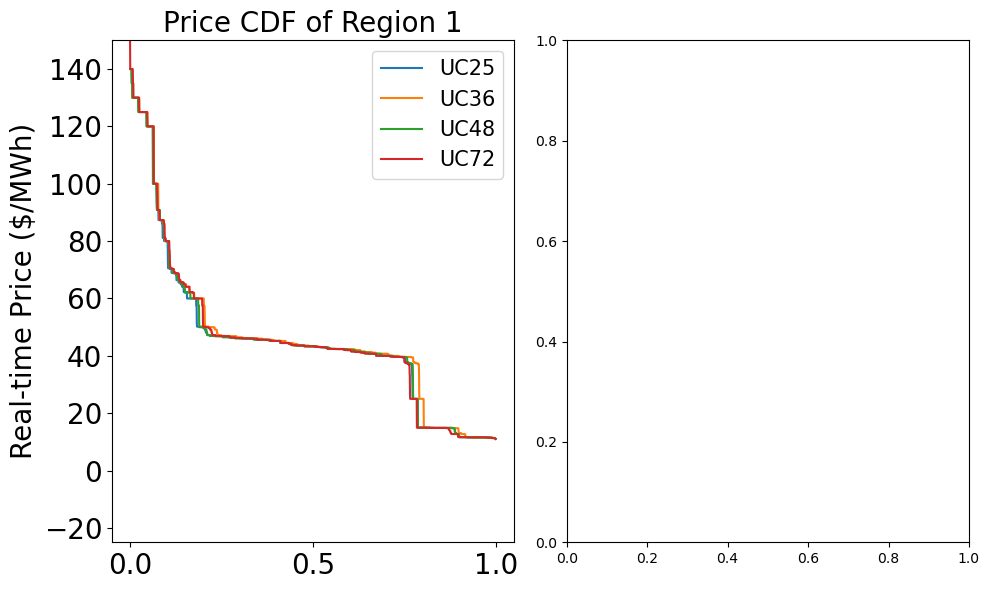

In [95]:
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Define the dataframes and labels
dataframes = [RTPriceUC25, RTPriceUC36, RTPriceUC48, RTPriceUC72]
labels = ['UC25', 'UC36', 'UC48', 'UC72']

# Loop through each region
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    # Plot the CDF for each dataframe
    for df, label in zip(dataframes, labels):
        sorted_vals = np.sort(df[col].values)[::-1]
        cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
        ax.plot(cdf, sorted_vals, label=label)

    # Set the axis labels and title
    ax.set_ylim(-25, 150)
    ax.set_title(f"Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)", fontsize=20)
    ax.legend(fontsize=15)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

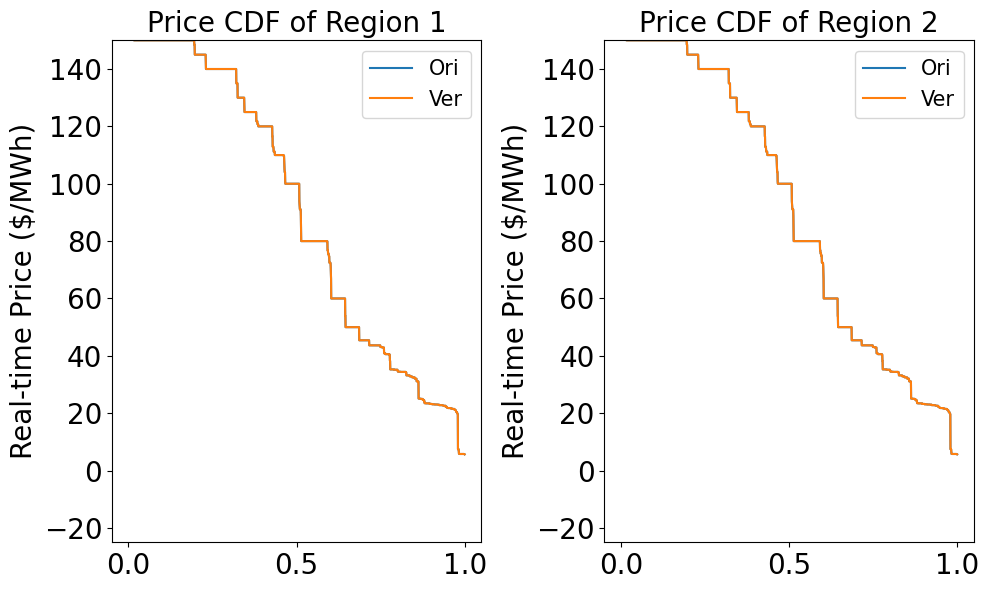

In [93]:
RTPriceED1Ori = pd.read_csv('output/archive/25UC1ED_RM0.03VOLL9000/EDprice.csv',header=None)*12
RTPriceED1Ver = pd.read_csv('output/UC25ED1_Ver/EDprice.csv',header=None)*12
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Define the dataframes and labels
dataframes = [RTPriceED1Ori, RTPriceED1Ver]
labels = ['Ori', 'Ver']

# Loop through each region
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    # Plot the CDF for each dataframe
    for df, label in zip(dataframes, labels):
        sorted_vals = np.sort(df[col].values)[::-1]
        cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
        ax.plot(cdf, sorted_vals, label=label)

    # Set the axis labels and title
    ax.set_ylim(-25, 150)
    ax.set_title(f"Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)", fontsize=20)
    ax.legend(fontsize=15)

# Adjust layout and show plot
plt.tight_layout()
plt.show()